In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
target_snr_per_bin = 23 # 23 and 28

velocity_dispersion_realizations = None
sample_number_for_each_setting = 1000

for rng in range(1, 4):
    for deg in range(2, 5):
        for template in range(1, 4):
            for quasar in ['A', 'B', 'C']:
                for directory_measurements in ["../kcwi_extractions/extracted_dispersions/",
                                               #"../kcwi_extractions_old/extracted_dispersions/"
                                              ]:
                    vd_name = 'VD_wave_rng_{}_deg_{}_global_temp_{}_quasar_sp_{}_SN_{}.txt'.format(
                        rng, deg, template, quasar, target_snr_per_bin
                    )

#                     directory_measurements = "../kcwi_extractions/extracted_dispersions/"
                    # object_name = "KCWI_RXJ1131_icubes_mosaic_0.1457"

                    url = directory_measurements + vd_name

                    extracted_vel_dis = np.loadtxt(url)

                    vel_dis = extracted_vel_dis[:, 1]
                    std_vel_dis = extracted_vel_dis[:, 3]

                    good_bins = np.ones_like(vel_dis)

                    if np.any(std_vel_dis > 200):
#                         print(vel_dis[std_vel_dis > 200], std_vel_dis[std_vel_dis > 200])
                        good_bins[std_vel_dis > 200] = 0
                        good_bins[std_vel_dis > 200] = 0

                    min_val = 50
                    if np.any(vel_dis < min_val):
#                         print(vel_dis[vel_dis < min_val], std_vel_dis[vel_dis < min_val])
                        good_bins[vel_dis < min_val] = 0
                        good_bins[vel_dis < min_val] = 0

                    max_val = 700
                    if np.any(vel_dis > max_val):
#                         print(vel_dis[vel_dis > max_val], std_vel_dis[vel_dis > max_val])
                        good_bins[vel_dis > max_val] = 0
                        good_bins[vel_dis > max_val] = 0


                    realizations = np.random.normal(loc=vel_dis[np.newaxis, :],
                                             scale=std_vel_dis[np.newaxis, :],
                                             size=(sample_number_for_each_setting, len(vel_dis))
                                            )

                    realizations[:, np.where(good_bins == 0)] = np.nan

                    if velocity_dispersion_realizations is None:
                        velocity_dispersion_realizations = realizations 
                    else:
                        velocity_dispersion_realizations = np.append(velocity_dispersion_realizations, 
                                                                     realizations, axis=0)

print(velocity_dispersion_realizations.shape)    

(81000, 41)


Text(0.5, 1.0, 'velocity dispersion in each bin')

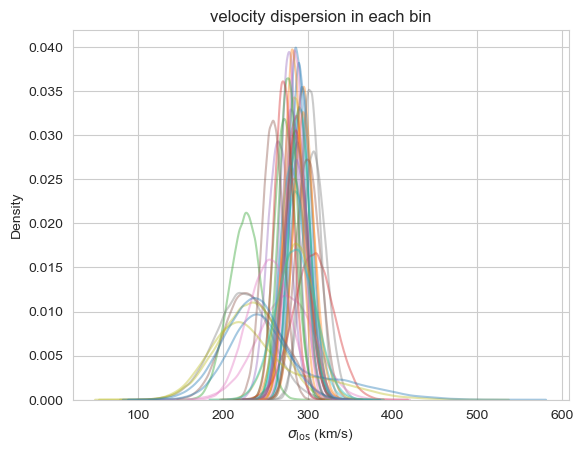

In [3]:
import seaborn as sns

ax = plt.figure().add_subplot(111)

for i in range(velocity_dispersion_realizations.shape[1]):
    sns.kdeplot(velocity_dispersion_realizations[:, i][velocity_dispersion_realizations[:, i] != np.nan], 
                ax=ax, alpha=0.4)

ax.set_xlabel(r'$\sigma_{\rm los}$ (km/s)')
ax.set_title('velocity dispersion in each bin')

In [4]:
import numpy.ma as ma


covariance_matrix = ma.cov(ma.masked_invalid(velocity_dispersion_realizations), rowvar=False)

covariance_matrix.filled(np.inf);

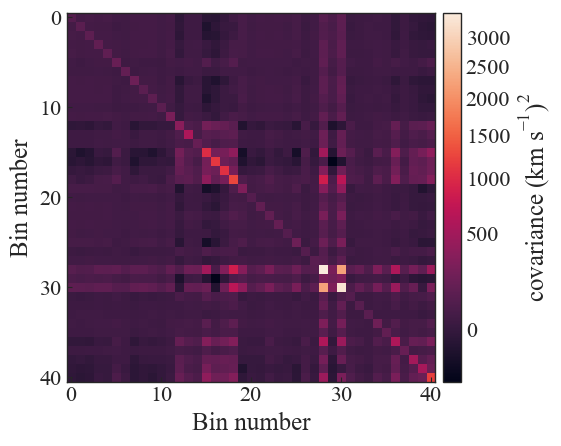

In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import simple_norm
import paperfig as pf

pf.set_fontscale(2.)

norm = simple_norm(covariance_matrix, 'sqrt')

fig = plt.figure()
ax = fig.add_subplot(111)


im = ax.imshow((covariance_matrix), norm=norm) #, cmap='gist')
#plt.colorbar(cbar, label=r'(km/s)${}^2$')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad='2%')
cbar = fig.colorbar(im, cax=cax, label=r'covariance (km s$^{-1}$)$^{2}$')

ax.set_xlabel('Bin number')
ax.set_ylabel('Bin number')

fig.tight_layout()

# fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/rxj1131_kcwi/figures/velocity_dispersion_covariance.pdf', 
#             bbox_inches='tight'
#            )

In [6]:
mean = ma.mean(ma.masked_invalid(velocity_dispersion_realizations), axis=0).data

mean.shape

(41,)

In [7]:
sys_vel_dis = np.sqrt(np.diag(covariance_matrix) - std_vel_dis**2)

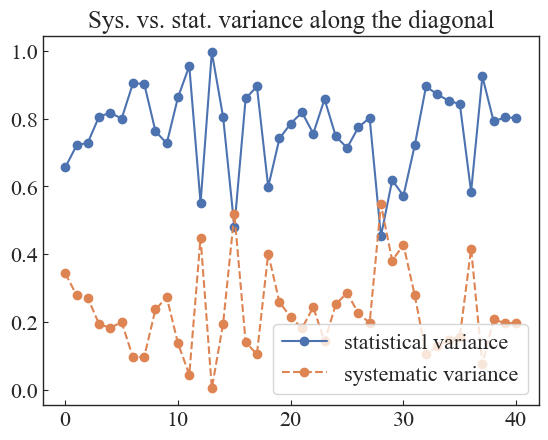

In [14]:
plt.plot(std_vel_dis**2/(np.diag(covariance_matrix)), 'o', ls='-',
         label='statistical variance')
plt.plot(sys_vel_dis**2/(np.diag(covariance_matrix)), 'o', ls='--',
         label='systematic variance')

plt.title('Sys. vs. stat. variance along the diagonal')
plt.legend(loc='lower right')

Text(0.5, 1.0, 'Sys. / Stat. variance')

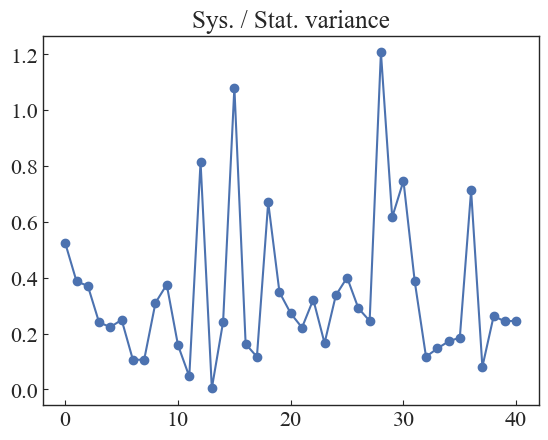

In [13]:
plt.plot(sys_vel_dis**2/std_vel_dis**2, 'o', ls='-')
plt.title('Sys. / Stat. variance')

Text(0.5, 1.0, 'Sys. / Stat. uncertainty')

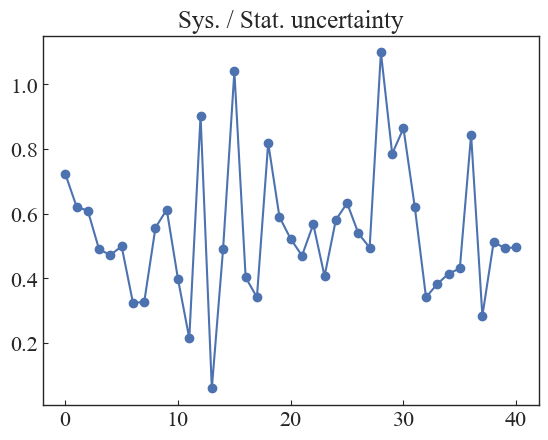

In [12]:
plt.plot(sys_vel_dis/np.array(std_vel_dis), 'o', ls='-')
plt.title('Sys. / Stat. uncertainty')

In [ ]:
    
np.savetxt('./data_products/systematic_marginalized_velocity_dispersion_snr_per_bin_{}_mean.txt'.format(target_snr_per_bin), mean)
np.savetxt('./data_products/systematic_marginalized_velocity_dispersion_snr_per_bin_{}_covariance.txt'.format(target_snr_per_bin), covariance_matrix)

# np.savetxt('./data_products/velcity_dispersion_binned_mean_snr_per_bin_{}.txt'.format(snr), mean)
# np.savetxt('./data_products/velcity_dispersion_binned_covmat_snr_per_bin_{}.txt'.format(snr), covariance_matrix)

In [8]:
from data_util import *

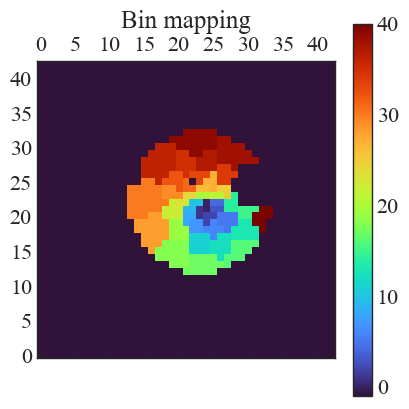

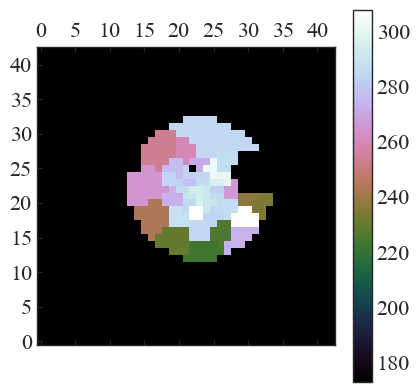

In [9]:
%matplotlib inline

bin_mapping = load_bin_mapping(target_snr_per_bin=target_snr_per_bin, 
                               plot=True, 
                               url='../kcwi_extractions/extracted_dispersions/'
                               'voronoi_2d_binning_KCWI_RXJ1131_icubes_mosaic_0.1457'
                               '_targetSN_{}_output.txt'.format(target_snr_per_bin)
                              )


im = plt.matshow(get_kinematics_maps(mean, bin_mapping), origin='lower', vmax=mean.max(), vmin=mean.min()-50, 
                 cmap='cubehelix'
                )
plt.colorbar(im)